# Activity: Build an XGBoost model

## Introduction

In this activity, you’ll build on the skills and techniques you learned in the decision tree and random forest lessons to construct your own XGBoost classification model. The XGBoost model is a very powerful extension of decision trees, so having a strong working familiarity with this process will strengthen your skills and resume as a data professional.

This activity is a continuation of the airlines project in which you built decision tree and random forest models. You will use the same data, but this time you will train, tune, and evaluate an XGBoost model. You’ll then compare the performance of all three models and decide which model is best. Finally, you’ll explore the feature importances of your model and identify the features that most contribute to customer satisfaction.


## Step 1: Imports

### Import packages

Begin with your import statements. First, import `pandas`, `numpy`, and `matplotlib` for data preparation. Next, import scikit-learn (`sklearn`) for model preparation and evaluation. Then, import `xgboost`, which provides the classification algorithm you'll implement to formulate your predictive model.

In [15]:
# Import relevant libraries and modules.
import numpy as np
import pandas as pd
import matplotlib as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings("ignore")

### Load the dataset

In [4]:
airline_data = pd.read_csv("Invistico_Airline.csv")

### Display the data

Examine the first 10 rows of data to familiarize yourself with the dataset.

In [5]:
# Display the first ten rows of data.
airline_data.head(10)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Male,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,...,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Female,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,...,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Male,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,...,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Female,Loyal Customer,56,Personal Travel,Business,73,0,0,0,...,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Male,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,...,2,2,2,4,5,3,4,2,30,26.0


### Display the data type for each column

Next, observe the types of data present within this dataset.

In [6]:
airline_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

## Step 2: Model preparation

Before you proceed with modeling, consider which metrics you will ultimately want to leverage to evaluate your model.

**Question:** Which metrics are most suited to evaluating this type of model?

- As this is a binary classfication problem, it will be important to evaluate not just accuracy, but the balance of false positives and false negatives that the model’s predictions provide. Therefore, precision, recall, and ultimately the F1 score will be excellent metrics to use.
- The ROC AUC (Area Under the Receiver Operating Characteristic) score is also suited to
this type of modeling.


### Prepare your data for predictions

You may have noticed when previewing your data that there are several non-numerical variables (`object` data types) within the dataset.

To prepare this DataFrame for modeling, first convert these variables into a numerical format.

In [7]:
# Convert the object predictor variables to numerical dummies.
airline_data_dummies = pd.get_dummies(airline_data,columns=["satisfaction","Customer Type","Type of Travel","Class"])

### Isolate your target and predictor variables
Separately define the target variable (`satisfaction`) and the features.

In [27]:
# Define the y (target) variable.
y = airline_data_dummies["satisfaction_satisfied"]

# Define the X (predictor) variables.

X = airline_data_dummies.drop(["satisfaction_satisfied","satisfaction_dissatisfied","Gender"], axis = 1)

In [12]:
y.value_counts(normalize=True)

satisfaction_satisfied
True     0.547328
False    0.452672
Name: proportion, dtype: float64

### Divide your data 

Divide your data into a training set (75% of the data) and test set (25% of the data). This is an important step in the process, as it allows you to reserve a part of the data that the model has not used to test how well the model generalizes (or performs) on new data.

In [28]:
# Perform the split operation on your data.
# Assign the outputs as follows: X_train, X_test, y_train, y_test.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state = 42)

## Step 3: Model building

### "Instantiate" your XGBClassifer

Before you fit your model to your airline dataset, first create the XGB Classifier model and define its objective. You'll use this model to fit and score different hyperparameters during the GridSearch cross-validation process.

In [29]:
# Define xgb to be your XGBClassifier.
xgb = XGBClassifier(objective="binary:logistic", random_state=0)

### Construct the GridSearch cross-validation 

Construct the GridSearch cross-validation using the model, parameters, and scoring metrics you defined. Additionally, define the number of folds and specify *which metric* from above will guide the refit strategy.

In [30]:
# Define parameters for tuning as `cv_params`.

cv_params = {"max_depth": [4, 6],
             "min_child_weight": [3, 5],
             "learning_rate": [0.1, 0.2, 0.3],
             "n_estimators": [100,200],
             "subsample": [0.7],
             "colsample_bytree": [0.7],
                }

scoring = {"accuracy", "precision", "recall", "f1"}

# Construct your GridSearch.
xgb_cv = GridSearchCV(xgb,cv_params,scoring = scoring,cv = 5,refit = "f1")

### Fit the GridSearch model to your training data

If your GridSearch takes too long, revisit the parameter ranges above and consider narrowing the range and reducing the number of estimators.

**Note:** The following cell might take several minutes to run.

In [31]:
%%time
# fit the GridSearch model to training data
xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

CPU times: total: 2h 22min 37s
Wall time: 32min 3s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.7]},
             refit='f1', scoring={'f1', 'precision', 'recall', 'accuracy'})

In [32]:
xgb_cv.best_score_

0.958174953808526

In [33]:
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 200,
 'subsample': 0.7}

### Save your model for reference using `pickle`

Use the `pickle` library you've already imported to save the output of this model.

In [ ]:
# Use `pickle` to save the trained model.
pickle.dump(xgb_cv, open("xgb_cv.sav", "wb"))

### Use your fitted model to create predictions for your test set

First, define `nb` to be the relevant algorithm from `sklearn`.`naive_bayes`. Then, fit your model to your training data. You will use this fitted model to create predictions for your test data.

## Step 4: Results and evaluation

### Formulate predictions on your test set

To evaluate the predictions yielded from your model, leverage a series of metrics and evaluation techniques from scikit-learn by examining the actual observed values in the test set relative to your model's prediction.

First, use your trained model to formulate predictions on your test set.

In [34]:
# Apply your model to predict on your test data. Call this output "y_pred".

y_pred = xgb_cv.predict(X_test)

### Leverage metrics to evaluate your model's performance

Apply a series of metrics from scikit-learn to assess your model. Specifically, print the accuracy score, precision score, recall score, and f1 score associated with your test data and predicted values.

In [35]:
# 1. Print your accuracy score.
ac_score = metrics.accuracy_score(y_test, y_pred)
print("accuracy score:", ac_score)

# 2. Print your precision score.

pc_score = metrics.precision_score(y_test, y_pred)
print("precision score:", pc_score)

# 3. Print your recall score.
rc_score = metrics.recall_score(y_test, y_pred)
print("recall score:", pc_score)

# 4. Print your f1 score.
f1_score = metrics.f1_score(y_test, y_pred)
print("f1 score:", f1_score)


accuracy score: 0.9563905143209116
precision score: 0.9678006599158039
recall score: 0.9678006599158039
f1 score: 0.9600451467268624


**Question:** Is your accuracy score alone sufficient to evaluate your model?

In classification problems, accuracy is useful to know but may not be the best metric to evaluate this model

**Question:** When observing the precision and recall scores of your model, how do you interpret these values, and is one more accurate than the other?

Precision and recall scores are both useful to evaluate the correct predictive capability of the model because they balance the false positives and false negatives inherent in prediction. The model shows a precision score of 0.967, suggesting the model is very good at predicting true positives. This means the model correctly predicts whether the airline passenger will be satisfied. The recall score of 0.9678 is also very good. This means that the model does a good job of correctly identifying dissatisfied passengers within the dataset. These two metrics combined give a better assessment of model performance than the accuracy metric does alone.

**Question:** What does your model's F1 score tell you, beyond what the other metrics provide?*

The F1 score balances the precision and recall performance to give a combined assessment of how well this model delivers predictions. In this case, the F1 score is 0.96, which suggests very strong predictive power in this model

### Gain clarity with the confusion matrix

Recall that a **confusion matrix** is a graphic that shows a model's true and false positives and true and false negatives. It helps to create a visual representation of the components feeding into the metrics above.

Create a confusion matrix based on your predicted values for the test set.

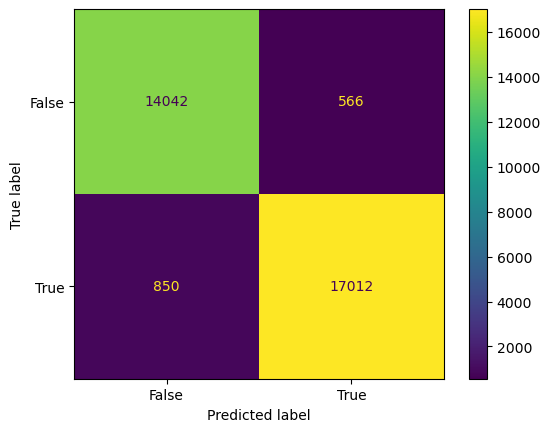

In [36]:
# Construct and display your confusion matrix.

# Construct the confusion matrix for your predicted and test values.

cm = metrics.confusion_matrix(y_test,y_pred)

# Create the display for your confusion matrix.
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb_cv.classes_)


# Plot the visual in-line.

disp.plot()


### Visualize most important features

`xgboost` has a built-in function to visualize the relative importance of the features in the model using `matplotlib`. Output and examine the feature importance of your model.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

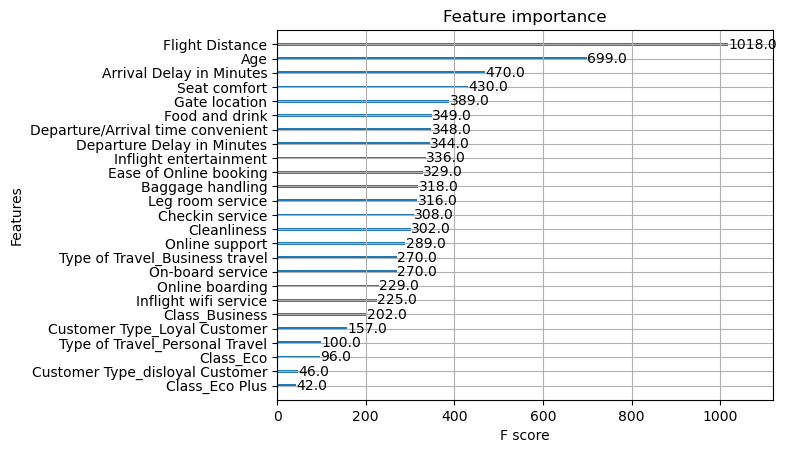

In [37]:
# Plot the relative feature importance of the predictor variables in your model.

plot_importance(xgb_cv.best_estimator_)

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged